# Train 3D-Convolutional Neural Network

In [21]:
import keras
import tensorflow
from keras.models import Sequential
from tensorflow.python.keras.layers.core import Dense, Dropout, Flatten
from tensorflow.python.keras.layers.convolutional import Conv3D, ZeroPadding3D
from tensorflow.python.keras.layers.pooling import MaxPooling3D
# from tensorflow.keras.layers.Normalization import BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.python.keras.layers.advanced_activations import PReLU

### CNTK and Keras

If you'd like to use CNTK as Keras backend, don't forget to set the environment variable:

    export KERAS_BACKEND=cntk
    
or update the Keras configuration file:

    {
        "epsilon": 1e-07, 
        "image_data_format": "channels_last", 
        "backend": "cntk", 
        "floatx": "float32" 
    }

Note that you don't need to change the Keras frontend codes for other backends (tensorflow or theano).

Please be aware that CNTK Keras support is in beta and there're known issues. Check the [page](https://docs.microsoft.com/en-us/cognitive-toolkit/Using-CNTK-with-Keras) and the issue tracker on GitHub.

In [16]:
import numpy as np
from glob import glob
import pandas as pd
import os
import math

resampled_file_list = glob("../preprocess/*.npz")

### Load the annotations

In [6]:
df_node = pd.read_csv("../inputs/CSVFILES/annotations.csv")

df_node.head()

seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  
2  876.374496     5.786348  
3 -391.081276     8.143262  
4 -405.493732    18.545150

### Data generation

- Create 48x48x48 3D cube
- Randomly choose locations for negative samples

In [7]:
def get_seriesuid(filepath):
    basename = os.path.basename(filepath)
    
    return basename[:-8]

def get_mhd_file(seriesuid):
    return get_filename(seriesuid)

def switch_xz(arr):
    return np.array([arr[2], arr[1], arr[0]])

def get_nodule_index(nodule_info, new_spacing, origin_zyx):
    nodule_coordinates = np.array(nodule_info[1:4]).astype(np.float32) # x,y,z

    nodule_index = ((switch_xz(nodule_coordinates) - origin_zyx) // new_spacing).astype(np.int16)  # z,y,x
    
    return nodule_index

def get_random_index(shape, margin, cube_size, nodule_index_list):
    while True:
        random_index = [np.random.randint(margin, s - margin) for s in shape]

        if nodule_index_list is None or len(nodule_index_list) == 0:
            return random_index

        dist = min([np.linalg.norm(nodule_index - random_index) for nodule_index in nodule_index_list])

        if dist > math.sqrt(cube_size * cube_size * 2):
            return random_index
        else:
            # print("too close to nodule {}, nodule_list={}".format(random_index, nodule_index_list))
            continue
            
def get_range(x, minx, maxx, dim):
    hdim = dim // 2

    if x - hdim <= minx:
        xs = minx
        xe = xs + dim
    elif x + hdim >= maxx:
        xe = maxx
        xs = xe - dim
    else:
        xs = x - hdim
        xe = xs + dim
    
    return xs, xe

def get_3D_cube(img_array, x, y, z, dim):
    xr = get_range(x, 0, img_array.shape[2], dim)
    yr = get_range(y, 0, img_array.shape[1], dim)
    zr = get_range(z, 0, img_array.shape[0], dim)

    return img_array[zr[0]:zr[1], yr[0]:yr[1], xr[0]:xr[1]]

def get_feature_label_pairs(npz_file, count=2, cube_size=48, random_center=True, positive_portion=0.5):
    npz_dict = np.load(npz_file)
    resampled_img = npz_dict['resampled_img'].astype(np.float16) # zyx
    origin_zyx = npz_dict['origin_zyx']
    new_spacing = npz_dict['new_spacing'] #zyx
    seriesuid = get_seriesuid(npz_file)
    mini_df_node = df_node[df_node['seriesuid'] == seriesuid]

    features_list = []
    labels_list = []

    if len(mini_df_node) > 0:
        nodule_index_list = [get_nodule_index(nodule_info, new_spacing, origin_zyx) for nodule_info in mini_df_node.values] #zyx
    else:
        nodule_index_list = []
        positive_portion = 0.0

    pos_count = math.ceil(count * positive_portion)
    neg_count = count - pos_count

    # positive
    if len(mini_df_node) > 0:
        for i in range(pos_count):
            nodule_index = nodule_index_list[np.random.randint(len(nodule_index_list))]
            xi, yi, zi = nodule_index[2], nodule_index[1], nodule_index[0]

            # Randomize center
            if random_center:
                randi = np.random.randint(-5, +5, 3)
                xi += randi[0]
                yi += randi[1]
                zi += randi[2]

            nodule_cube = get_3D_cube(resampled_img, xi, yi, zi, cube_size)

            features_list.append(np.reshape(nodule_cube, [cube_size, cube_size, cube_size, 1]))
            labels_list.append(1)

    # negative
    for i in range(neg_count):
        random_index = get_random_index(resampled_img.shape, 0, cube_size, nodule_index_list)

        random_cube = get_3D_cube(resampled_img, random_index[2], random_index[1], random_index[0], cube_size)

        features_list.append(np.reshape(random_cube, [cube_size, cube_size, cube_size, 1]))
        labels_list.append(0)

    return features_list, labels_list

### Inspect samples (3D cubes)

In [8]:
npz_file = resampled_file_list[6]
seriesuid = get_seriesuid(npz_file)
df_node[df_node['seriesuid'] == seriesuid]

seriesuid     coordX      coordY  \
729  1.3.6.1.4.1.14519.5.2.1.6279.6001.276556509002... -67.459503 -247.744211   
730  1.3.6.1.4.1.14519.5.2.1.6279.6001.276556509002... -97.690876 -134.068054   

         coordZ  diameter_mm  
729 -211.095340     7.744222  
730 -187.094883     6.690036

In [10]:
cube_list, label_list = get_feature_label_pairs(npz_file, count=8)

label_list

[1, 1, 1, 1, 0, 0, 0, 0]

#### Positive example

(48, 48, 48, 1)


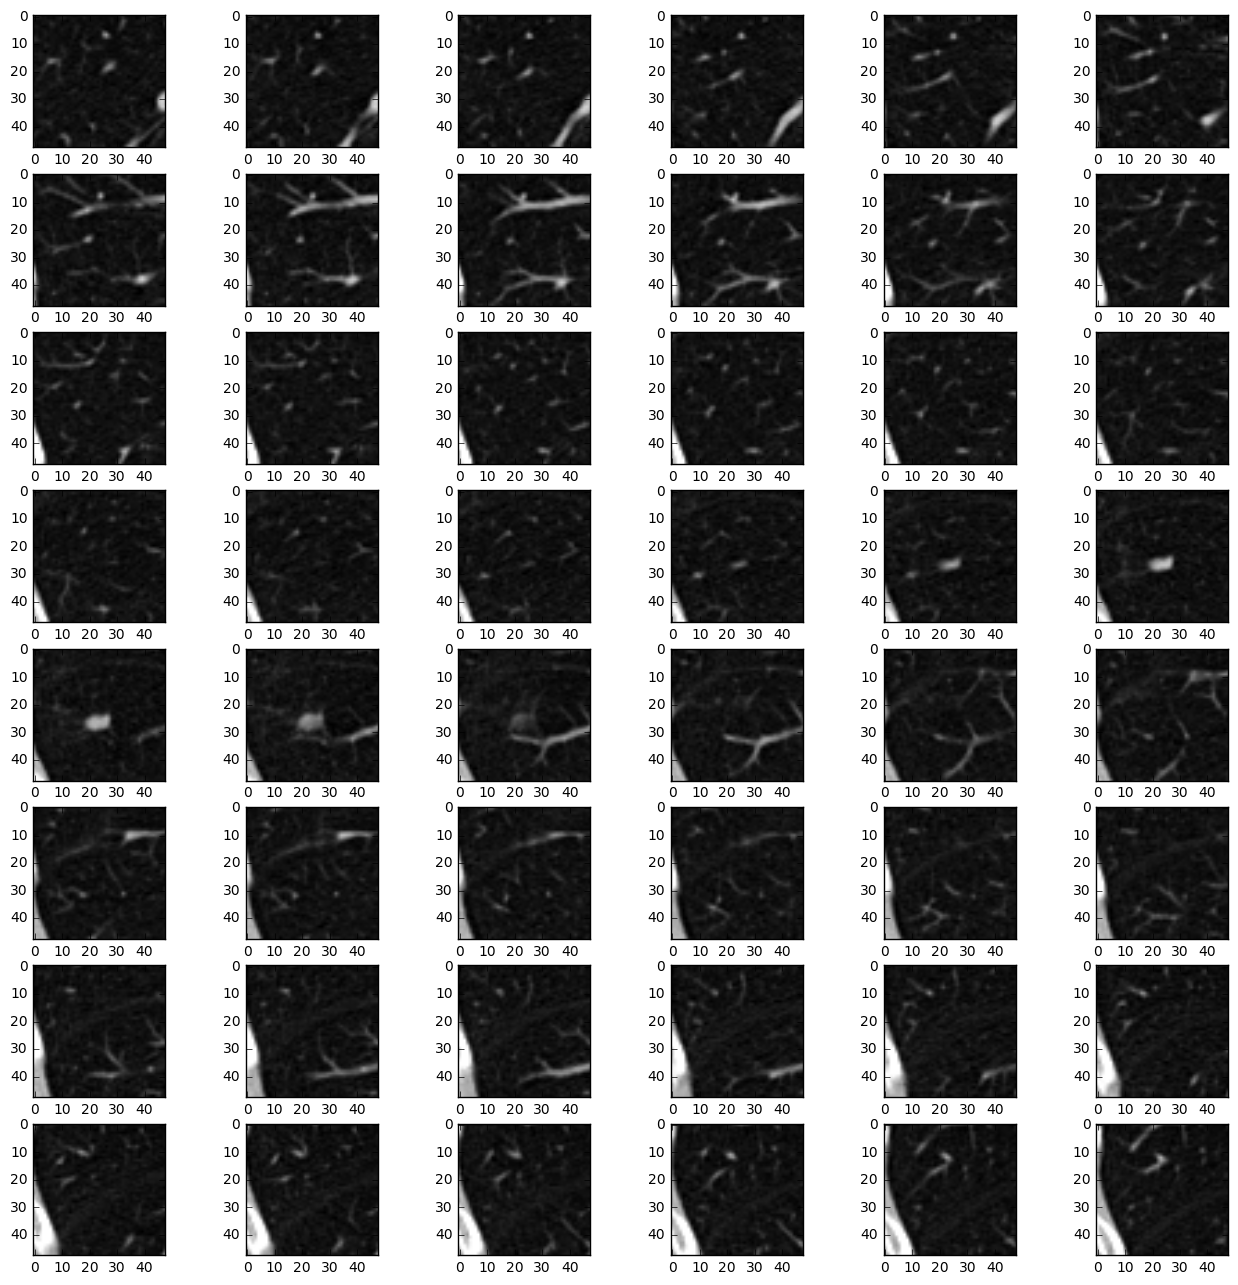

In [28]:
def plot_input_cube(cube):
    plt.figure(figsize=(16, 16))
    for i in range(0, 48):
        plt.subplot(8, 6, i + 1)
        plt.imshow(np.reshape(cube[i], (48, 48)).astype(np.float32), cmap=plt.cm.gray, vmax=1, vmin=0)

print(cube_list[0].shape)
plot_input_cube(cube_list[0])

### Negative example

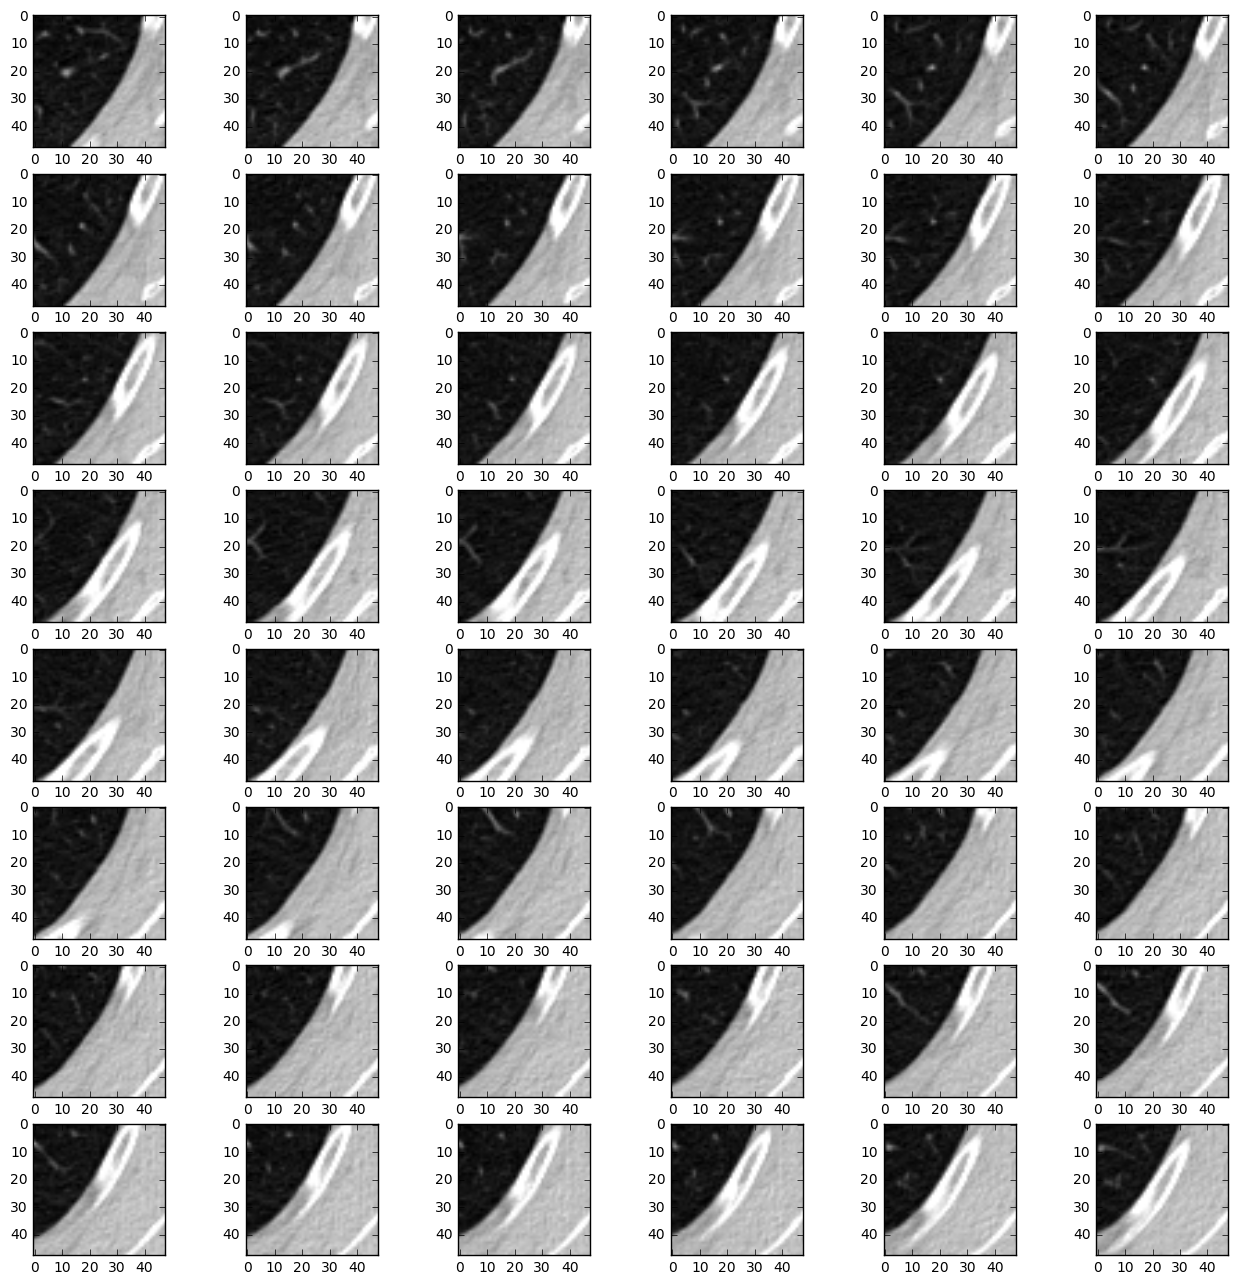

In [27]:
plot_input_cube(cube_list[5])

### Data Sequence

For parallel mini-batch preparation

In [13]:
class DataSequence(Sequence):
    def __init__(self, file_list, cube_size, batch_size):
        self.file_list = file_list
        self.cube_size = cube_size
        self.batch_size = batch_size

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        npz_file = self.file_list[idx]

        fl, ll = get_feature_label_pairs(npz_file, count=self.batch_size, cube_size=self.cube_size, random_center=True)

        # import collections
        # print(idx, collections.Counter(ll))

        return np.asarray(fl), np.asarray(ll)

### Define 3D-CNN

In [11]:
def get_model(input_dim=48):
    model = Sequential()
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='valid', strides=(1, 1, 1), input_shape=(input_dim, input_dim, input_dim, 1)))
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='valid', strides=(1, 1, 1)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='valid'))

    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='valid', strides=(1, 1, 1)))
    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='valid', strides=(1, 1, 1)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='valid'))

    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='valid', strides=(1, 1, 1)))
    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='valid', strides=(1, 1, 1)))

    model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='valid', strides=(1, 1, 1)))
    model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='valid', strides=(1, 1, 1)))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.003, momentum=0.9, nesterov=True), metrics=['accuracy'])

    return model

In [15]:
input_dim = 48
model = get_model(input_dim)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 46, 46, 46, 32)    896       
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 44, 44, 44, 32)    27680     
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 22, 22, 22, 32)    0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 20, 20, 20, 64)    55360     
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 18, 18, 18, 64)    110656    
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 9, 9, 9, 64)       0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 7, 7, 7, 128)      221312    
__________

### Training

In [22]:
from datetime import datetime as dt
def get_experiment_id():
    time_str = dt.now().strftime('%Y-%m-%d-%H-%M-%S')
    experiment_id = 'base_{}'.format(time_str)

    return experiment_id

experiment_id = get_experiment_id()

In [ ]:
resampled_file_list = glob("../preprocess/*.npz")
n_val_files = 80
val_file_list = resampled_file_list[:n_val_files]
train_file_list = resampled_file_list[n_val_files:]

batch_size = 8

train_gen = DataSequence(train_file_list, input_dim, batch_size)
validate_gen = DataSequence(val_file_list, input_dim, batch_size)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint(experiment_id + "-val_loss_checkpoint.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1, mode='auto', epsilon=0.01, cooldown=0, min_lr=1e-6)
]

history = model.fit_generator(generator=train_gen, 
                              validation_data=validate_gen,
                              steps_per_epoch=len(train_file_list),
                              validation_steps=len(val_file_list) * 3,
                              verbose=1,
                              epochs=100,
                              callbacks=callbacks,
                              workers=12, # recommend: number of cpu cores
                              use_multiprocessing=True)

Epoch 1/100
808/808 [==============================] - 1104s - loss: 0.4391 - acc: 0.8038 - val_loss: 0.3821 - val_acc: 0.8677
Epoch 2/100
808/808 [==============================] - 1130s - loss: 0.3049 - acc: 0.8820 - val_loss: 0.3064 - val_acc: 0.9000
Epoch 3/100
808/808 [==============================] - 1131s - loss: 0.1498 - acc: 0.9482 - val_loss: 0.1743 - val_acc: 0.9417
Epoch 6/100
808/808 [==============================] - 1130s - loss: 0.1319 - acc: 0.9561 - val_loss: 0.2037 - val_acc: 0.9344
Epoch 7/100
808/808 [==============================] - 1130s - loss: 0.1202 - acc: 0.9621 - val_loss: 0.1696 - val_acc: 0.9427
Epoch 8/100
808/808 [==============================] - 1130s - loss: 0.0932 - acc: 0.9706 - val_loss: 0.1852 - val_acc: 0.9448
Epoch 10/100
808/808 [==============================] - 1131s - loss: 0.0828 - acc: 0.9763 - val_loss: 0.1689 - val_acc: 0.9453
Epoch 12/100
808/808 [==============================] - 1130s - loss: 0.0581 - acc: 0.9836 - val_loss: 0.1763 

### Save and load model

In [23]:
model.save(experiment_id + "-final_model_checkpoint.hdf5")

# final_model = keras.models.load_model(experiment_id + "-final_model_checkpoint.hdf5")

### Show learning curves

In [18]:
print(history.history.keys())

dict_keys(['val_acc', 'loss', 'val_loss', 'acc', 'lr'])


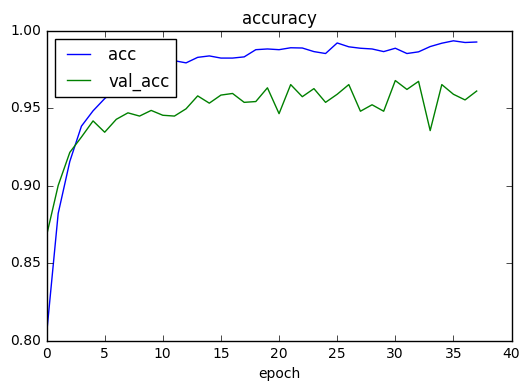

In [19]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

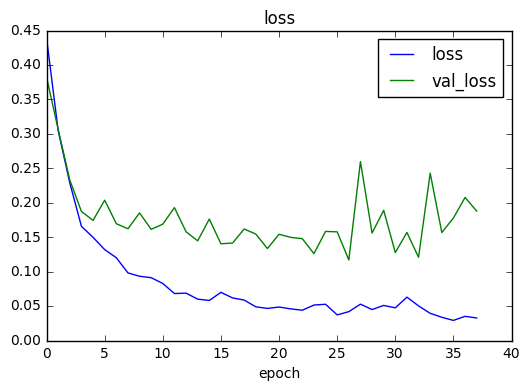

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

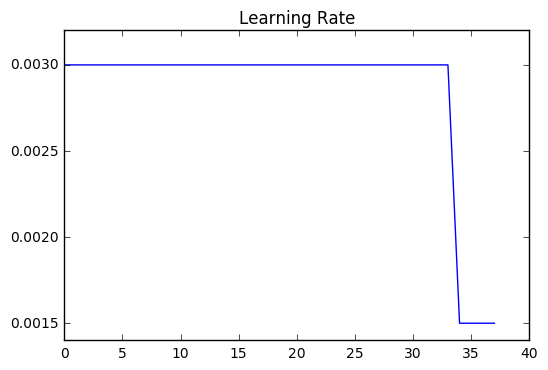

In [21]:
plt.plot(history.history['lr'])
plt.title('Learning Rate')
plt.show()